In [2]:
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
import librosa
from dataset import ALCDataset

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
SR = 16000
print(os.getcwd())

/content


### Load data

In [6]:
alc_dataset = ALCDataset('/content/drive/MyDrive/alc')
data_train, label_train = alc_dataset.load_data('train', percentage=1.0, num_threads=4)
data_dev1, label_dev1 = alc_dataset.load_data('d1', percentage=1.0, num_threads=4)
data_dev2, label_dev2 = alc_dataset.load_data('d2', percentage=1.0, num_threads=4)
data_test, label_test = alc_dataset.load_data('test', percentage=1.0, num_threads=4)

In [7]:
assert len(data_train) == len(label_train)
assert len(data_dev1) == len(label_dev1)
assert len(data_dev2) == len(label_dev2)
assert len(data_test) == len(label_test)

print('#train: {}'.format(len(data_train)))
print('#dev1: {}'.format(len(data_dev1)))
print('#dev2: {}'.format(len(data_dev2)))
print('#test: {}'.format(len(data_test)))

#train: 5400
#dev1: 3960
#dev2: 1500
#test: 3000


### Feature extraction

In [8]:
class ALCFeature:
    def __init__(self, sr):
        self.sr = sr
        
    def delete_silence(self, audio, top_db=20):
        result = []
        intervals = librosa.effects.split(audio, top_db=top_db, frame_length=2048, hop_length=512)
        for interval in intervals:
            result.append(audio[interval[0]: interval[1]])
        result = np.concatenate(result)
        return result
        
    def get_mfcc(self, data, label, n_mfcc=20, wsize=0.1, concat=5, scale=True):
        x_mfcc = []
        y_mfcc = []
        record_mfcc = []
        wsize = int(wsize * self.sr)
        for i in tqdm(range(len(data)), ncols=100, ascii=True, desc='MFCC feature'):
            audio = self.delete_silence(data[i])
            x = librosa.feature.mfcc(audio, sr=self.sr, n_mfcc=n_mfcc, n_fft=2048, hop_length=512, win_length=wsize, window='hann')
            if scale:
                x = x - np.min(x, axis=1, keepdims=True)
            for j in range(x.shape[1] // concat):
                slice_ = x[:, j * concat: (j + 1) * concat]
                x_mfcc.append(slice_.flatten())
                y_mfcc.append(label[i])
                record_mfcc.append(i)
        x_mfcc = np.stack(x_mfcc)
        y_mfcc = np.array(y_mfcc)
        record_mfcc = np.array(record_mfcc)
        return x_mfcc, y_mfcc, record_mfcc
    
    def get_pncc(self, data, label):
        pass
    
    def get_cqt(self, data, label, n_chroma=12, wsize=0.1, concat=5, scale=True):
        x_cqt = []
        y_cqt = []
        record_cqt = []
        wind = np.hamming(int(wsize * self.sr))
        for i in tqdm(range(len(data)), ncols=100, ascii=True, desc='CQT feature'):
            audio = self.delete_silence(data[i])
            x = librosa.feature.chroma_cqt(audio, sr=self.sr, n_chroma=n_chroma, hop_length=512, window=wind)
            if scale:
                x = x - np.min(x, axis=1, keepdims=True)
            for j in range(x.shape[1] // concat):
                slice_ = x[:, j * concat: (j + 1) * concat]
                x_cqt.append(slice_.flatten())
                y_cqt.append(label[i])
                record_cqt.append(i)
        x_cqt = np.stack(x_cqt)
        y_cqt = np.array(y_cqt)
        record_cqt = np.array(record_cqt)
        return x_cqt, y_cqt, record_cqt

In [9]:
alc_feature = ALCFeature(SR)
smote = SMOTE(random_state=0)

# # MFCC
# x_train, y_train, record_train = alc_feature.get_mfcc(data_train, label_train)
# x_balance, y_balance = smote.fit_resample(x_train, y_train)
# x_dev1, y_dev1, record_dev1 = alc_feature.get_mfcc(data_dev1, label_dev1)
# x_dev2, y_dev2, record_dev2 = alc_feature.get_mfcc(data_dev2, label_dev2)
# x_test, y_test, record_test = alc_feature.get_mfcc(data_test, label_test)

# CQT test case


In [10]:
pca = sklearn.decomposition.PCA(n_components=50)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_balance = pca.transform(x_balance)
x_dev1 = pca.transform(x_dev1)
x_dev2 = pca.transform(x_dev2)
x_test = pca.transform(x_test)

NameError: ignored

### Classification model

In [11]:
class ALCModel:
    def __init__(self, method, verbose=None):
        if method == 'lr':
            if verbose is None:
                verbose = 0
            self.clf = LogisticRegression(verbose=verbose)
        elif method == 'svm':
            if verbose is None:
                verbose = False
            self.clf = SVC(C=1.0, kernel='rbf', verbose=verbose)
        elif method == 'forest':
            if verbose is None:
                verbose = 0
            self.clf = RandomForestClassifier(n_estimators=100, verbose=verbose)
        elif method == 'adaboost':
            self.clf = AdaBoostClassifier(n_estimators=100)
        else:
            pass
        
    def fit(self, x, y):
        self.clf.fit(x, y)
    
    def predict(self, x, record):
        prediction = []
        probability = []
        raw_pred = self.clf.predict(x)
        for i in range(record[-1] + 1):
            this_pred = raw_pred[record == i]
            if len(this_pred) == 0:
                this_prob = np.random.uniform(low=0.0, high=1.0)
                this_pred = np.random.choice([0, 1])              
            else:
                this_prob = np.mean(this_pred)
                this_pred = np.argmax(np.bincount(this_pred))
            prediction.append(this_pred)
            probability.append(this_prob)
        prediction = np.array(prediction)
        probability = np.array(probability)
        return prediction, probability
    
    def evaluate(self, x, record, label, roc=False):
        pred, prob = self.predict(x, record)
        acc = np.mean(pred == label)
        report = sklearn.metrics.classification_report(label, pred)
        if roc:
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(label, prob)
            plt.figure()
            plt.plot(fpr, tpr)
            plt.title('ROC Curve')
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.show()
        return acc, report

In [ ]:
wsize_list =  [0.3,0.5]
n_list = [50]


acc_list_svm = []
wsize_list_svm =[]
n_list_svm = []
for w in (wsize_list):
  for n in (n_list):
    x_train, y_train, record_train = alc_feature.get_cqt(data_train, label_train, wsize = w)
    x_balance, y_balance = smote.fit_resample(x_train, y_train)
    x_dev1, y_dev1, record_dev1 = alc_feature.get_cqt(data_dev1, label_dev1, wsize = w)
    x_dev2, y_dev2, record_dev2 = alc_feature.get_cqt(data_dev2, label_dev2, wsize = w)
    x_test, y_test, record_test = alc_feature.get_cqt(data_test, label_test, wsize = w)

    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_balance = pca.transform(x_balance)
    x_dev1 = pca.transform(x_dev1)
    x_dev2 = pca.transform(x_dev2)
    x_test = pca.transform(x_test)

    model = ALCModel('svm')
    # model.fit(x_train, y_train)
    model.fit(x_balance, y_balance)
    acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
    acc_list_svm.append(acc)
    wsize_list_svm.append(w)
    n_list_svm.append(n)
    print(report)

CQT feature: 100%|##############################################| 3000/3000 [04:50<00:00, 10.32it/s]


In [ ]:
wsize_list =  [0.1,0.3,0.5]
n_list = [50]


acc_list_svm = []
wsize_list_svm =[]
n_list_svm = []
for w in (wsize_list):
  for n in (n_list):
    x_train, y_train, record_train = alc_feature.get_cqt(data_train, label_train, wsize = w)
    x_balance, y_balance = smote.fit_resample(x_train, y_train)
    x_dev1, y_dev1, record_dev1 = alc_feature.get_cqt(data_dev1, label_dev1, wsize = w)
    x_dev2, y_dev2, record_dev2 = alc_feature.get_cqt(data_dev2, label_dev2, wsize = w)
    x_test, y_test, record_test = alc_feature.get_cqt(data_test, label_test, wsize = w)

    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_balance = pca.transform(x_balance)
    x_dev1 = pca.transform(x_dev1)
    x_dev2 = pca.transform(x_dev2)
    x_test = pca.transform(x_test)

    model = ALCModel('svm')
    # model.fit(x_train, y_train)
    model.fit(x_balance, y_balance)
    acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
    acc_list_svm.append(acc)
    wsize_list_svm.append(w)
    n_list_svm.append(n)
    print(report)

In [ ]:
print(acc_list_svm)
print(wsize_list_svm)
print(n_list_svm)

[0.5826666666666667]
[0.1]
[]


In [ ]:


acc_list_lr = []
wsize_list_lr =[]
n_list_lr = []
for w in (wsize_list):
  for n in (n_list):
    x_train, y_train, record_train = alc_feature.get_cqt(data_train, label_train, wsize = w)
    x_balance, y_balance = smote.fit_resample(x_train, y_train)
    x_dev1, y_dev1, record_dev1 = alc_feature.get_cqt(data_dev1, label_dev1, wsize = w)
    x_dev2, y_dev2, record_dev2 = alc_feature.get_cqt(data_dev2, label_dev2, wsize = w)
    x_test, y_test, record_test = alc_feature.get_cqt(data_test, label_test, wsize = w)

    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_balance = pca.transform(x_balance)
    x_dev1 = pca.transform(x_dev1)
    x_dev2 = pca.transform(x_dev2)
    x_test = pca.transform(x_test)

    model = ALCModel('lr')
    # model.fit(x_train, y_train)
    model.fit(x_balance, y_balance)
    acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
    acc_list_lr.append(acc)
    wsize_list_lr.append(w)
    n_list_lr.append(n)
    print(report)

acc_list_forest = []
wsize_list_forest =[]
n_list_forest = []
for w in (wsize_list):
  for n in (n_list):
    x_train, y_train, record_train = alc_feature.get_cqt(data_train, label_train, wsize = w)
    x_balance, y_balance = smote.fit_resample(x_train, y_train)
    x_dev1, y_dev1, record_dev1 = alc_feature.get_cqt(data_dev1, label_dev1, wsize = w)
    x_dev2, y_dev2, record_dev2 = alc_feature.get_cqt(data_dev2, label_dev2, wsize = w)
    x_test, y_test, record_test = alc_feature.get_cqt(data_test, label_test, wsize = w)


    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_balance = pca.transform(x_balance)
    x_dev1 = pca.transform(x_dev1)
    x_dev2 = pca.transform(x_dev2)
    x_test = pca.transform(x_test)

    model = ALCModel('forest')
    # model.fit(x_train, y_train)
    model.fit(x_balance, y_balance)
    acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
    acc_list_forest.append(acc)
    wsize_list_forest.append(w)
    n_list_forest.append(n)
    print(report)

acc_list_ada = []
wsize_list_ada =[]
n_list_ada = []
for w in (wsize_list):
  for n in (n_list):
    x_train, y_train, record_train = alc_feature.get_cqt(data_train, label_train, wsize = w)
    x_balance, y_balance = smote.fit_resample(x_train, y_train)
    x_dev1, y_dev1, record_dev1 = alc_feature.get_cqt(data_dev1, label_dev1, wsize = w)
    x_dev2, y_dev2, record_dev2 = alc_feature.get_cqt(data_dev2, label_dev2, wsize = w)
    x_test, y_test, record_test = alc_feature.get_cqt(data_test, label_test, wsize = w)


    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_balance = pca.transform(x_balance)
    x_dev1 = pca.transform(x_dev1)
    x_dev2 = pca.transform(x_dev2)
    x_test = pca.transform(x_test)

    model = ALCModel('adaboost')
    # model.fit(x_train, y_train)
    model.fit(x_balance, y_balance)
    acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
    print(report)
    acc_list_ada.append(acc)
    wsize_list_ada.append(w)
    n_list_ada.append(n)
    print(report)
  

CQT feature: 100%|##############################################| 3000/3000 [04:39<00:00, 10.75it/s]


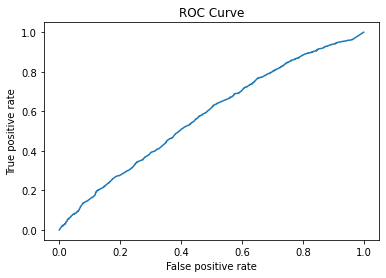

CQT feature:   0%|                                                         | 0/5400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.57      0.48      0.52      1500
           1       0.55      0.64      0.59      1500

    accuracy                           0.56      3000
   macro avg       0.56      0.56      0.56      3000
weighted avg       0.56      0.56      0.56      3000

              precision    recall  f1-score   support

           0       0.57      0.48      0.52      1500
           1       0.55      0.64      0.59      1500

    accuracy                           0.56      3000
   macro avg       0.56      0.56      0.56      3000
weighted avg       0.56      0.56      0.56      3000



CQT feature:  83%|######################################        | 3273/3960 [05:28<01:57,  5.84it/s]

In [ ]:
wsize_list =  [0.1,0.2,0.3,0.4]
n_list = [50]
acc_list_ada = []
wsize_list_ada =[]
n_list_ada = []
for w in (wsize_list):
  for n in (n_list):
    x_train, y_train, record_train = alc_feature.get_cqt(data_train, label_train, wsize = w)
    x_balance, y_balance = smote.fit_resample(x_train, y_train)
    x_dev1, y_dev1, record_dev1 = alc_feature.get_cqt(data_dev1, label_dev1, wsize = w)
    x_dev2, y_dev2, record_dev2 = alc_feature.get_cqt(data_dev2, label_dev2, wsize = w)
    x_test, y_test, record_test = alc_feature.get_cqt(data_test, label_test, wsize = w)


    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_balance = pca.transform(x_balance)
    x_dev1 = pca.transform(x_dev1)
    x_dev2 = pca.transform(x_dev2)
    x_test = pca.transform(x_test)

    model = ALCModel('adaboost')
    # model.fit(x_train, y_train)
    model.fit(x_balance, y_balance)
    acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
    print(report)
    acc_list_ada.append(acc)
    wsize_list_ada.append(w)
    n_list_ada.append(n)
    print(report)
  

CQT feature: 100%|##############################################| 3000/3000 [04:38<00:00, 10.77it/s]


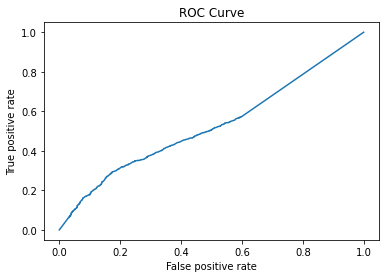

CQT feature:   0%|                                                         | 0/5400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.53      0.71      0.61      1500
           1       0.56      0.37      0.45      1500

    accuracy                           0.54      3000
   macro avg       0.55      0.54      0.53      3000
weighted avg       0.55      0.54      0.53      3000



CQT feature: 100%|##############################################| 3000/3000 [04:43<00:00, 10.60it/s]


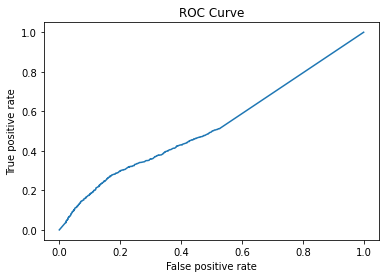

CQT feature:   0%|                                                         | 0/5400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.53      0.78      0.63      1500
           1       0.59      0.31      0.40      1500

    accuracy                           0.55      3000
   macro avg       0.56      0.55      0.52      3000
weighted avg       0.56      0.55      0.52      3000



CQT feature: 100%|##############################################| 3000/3000 [04:45<00:00, 10.52it/s]


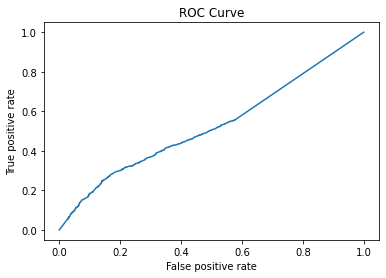

CQT feature:   0%|                                                         | 0/5400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.53      0.73      0.61      1500
           1       0.57      0.34      0.43      1500

    accuracy                           0.54      3000
   macro avg       0.55      0.54      0.52      3000
weighted avg       0.55      0.54      0.52      3000



CQT feature: 100%|##############################################| 3000/3000 [04:44<00:00, 10.53it/s]


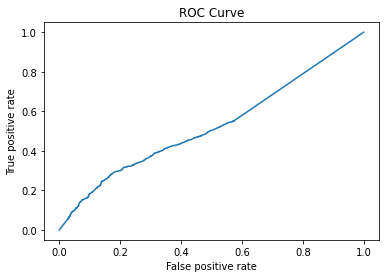

              precision    recall  f1-score   support

           0       0.53      0.74      0.62      1500
           1       0.56      0.34      0.43      1500

    accuracy                           0.54      3000
   macro avg       0.55      0.54      0.52      3000
weighted avg       0.55      0.54      0.52      3000



In [12]:
wsize_list =  [0.1,0.2,0.3,0.4]
n_list = [50]


acc_list_lr = []
wsize_list_lr =[]
n_list_lr = []
for w in (wsize_list):
  for n in (n_list):
    x_train, y_train, record_train = alc_feature.get_cqt(data_train, label_train, wsize = w)
    x_balance, y_balance = smote.fit_resample(x_train, y_train)
    x_dev1, y_dev1, record_dev1 = alc_feature.get_cqt(data_dev1, label_dev1, wsize = w)
    x_dev2, y_dev2, record_dev2 = alc_feature.get_cqt(data_dev2, label_dev2, wsize = w)
    x_test, y_test, record_test = alc_feature.get_cqt(data_test, label_test, wsize = w)

    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_balance = pca.transform(x_balance)
    x_dev1 = pca.transform(x_dev1)
    x_dev2 = pca.transform(x_dev2)
    x_test = pca.transform(x_test)

    model = ALCModel('lr')
    # model.fit(x_train, y_train)
    model.fit(x_balance, y_balance)
    acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
    acc_list_lr.append(acc)
    wsize_list_lr.append(w)
    n_list_lr.append(n)
    print(report)

CQT feature: 100%|##############################################| 3000/3000 [04:41<00:00, 10.67it/s]


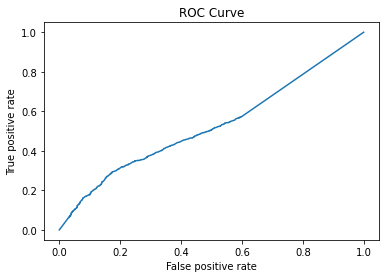

CQT feature:   0%|                                                         | 0/5400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.53      0.71      0.61      1500
           1       0.56      0.37      0.45      1500

    accuracy                           0.54      3000
   macro avg       0.55      0.54      0.53      3000
weighted avg       0.55      0.54      0.53      3000



CQT feature: 100%|##############################################| 3000/3000 [04:41<00:00, 10.67it/s]


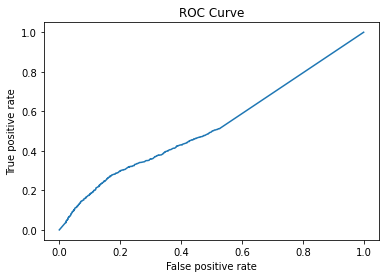

CQT feature:   0%|                                                         | 0/5400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.53      0.78      0.63      1500
           1       0.59      0.31      0.40      1500

    accuracy                           0.55      3000
   macro avg       0.56      0.55      0.52      3000
weighted avg       0.56      0.55      0.52      3000



CQT feature: 100%|##############################################| 3000/3000 [04:42<00:00, 10.63it/s]


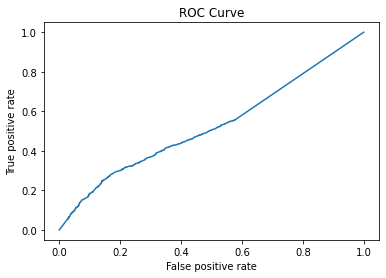

CQT feature:   0%|                                                         | 0/5400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.53      0.73      0.61      1500
           1       0.57      0.34      0.43      1500

    accuracy                           0.54      3000
   macro avg       0.55      0.54      0.52      3000
weighted avg       0.55      0.54      0.52      3000



CQT feature: 100%|##############################################| 3000/3000 [04:43<00:00, 10.57it/s]


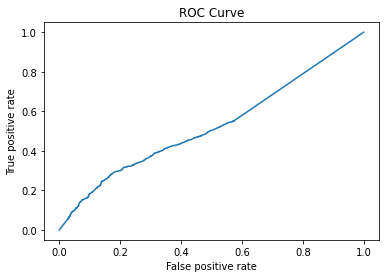

              precision    recall  f1-score   support

           0       0.53      0.74      0.62      1500
           1       0.56      0.34      0.43      1500

    accuracy                           0.54      3000
   macro avg       0.55      0.54      0.52      3000
weighted avg       0.55      0.54      0.52      3000



In [13]:
wsize_list =  [0.1,0.2,0.3,0.4]
n_list = [55]


acc_list_lr = []
wsize_list_lr =[]
n_list_lr = []
for w in (wsize_list):
  for n in (n_list):
    x_train, y_train, record_train = alc_feature.get_cqt(data_train, label_train, wsize = w)
    x_balance, y_balance = smote.fit_resample(x_train, y_train)
    x_dev1, y_dev1, record_dev1 = alc_feature.get_cqt(data_dev1, label_dev1, wsize = w)
    x_dev2, y_dev2, record_dev2 = alc_feature.get_cqt(data_dev2, label_dev2, wsize = w)
    x_test, y_test, record_test = alc_feature.get_cqt(data_test, label_test, wsize = w)

    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_balance = pca.transform(x_balance)
    x_dev1 = pca.transform(x_dev1)
    x_dev2 = pca.transform(x_dev2)
    x_test = pca.transform(x_test)

    model = ALCModel('lr')
    # model.fit(x_train, y_train)
    model.fit(x_balance, y_balance)
    acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
    acc_list_lr.append(acc)
    wsize_list_lr.append(w)
    n_list_lr.append(n)
    print(report)

In [ ]:
model = ALCModel('lr')
# model.fit(x_train, y_train)
model.fit(x_balance, y_balance)
acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
print(report)

In [ ]:
model = ALCModel('forest')
# model.fit(x_train, y_train)
model.fit(x_balance, y_balance)
acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
print(report)

In [ ]:
model = ALCModel('adaboost')
# model.fit(x_train, y_train)
model.fit(x_balance, y_balance)
acc, report = model.evaluate(x_test, record_test, label_test, roc=True)
print(report)